# Mini-batch

```text
- Variation of gradient descent that splits the training data into smalleer batches that are used for calculating the model error and updating the model weights.
- Batch size is often powers of 2. e.g. between 2 to 512.
- Training in batches can reduce the computational time because of vectorization (matrix multiplication instead of for-loops).
- It smoothens learning by averaging the loss over many samples thereby reducing overfitting.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom import
from src.utilities import create_iris_data, smooth


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

In [3]:
# Load Iris data
X, y = create_iris_data()

TEST_SIZE, RAMDOM_STATE = 0.2, 123
BATCH_SIZE = 16

# Split the data
X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RAMDOM_STATE,
)

X_train.shape, X_validation.shape

Shape of X: torch.Size([150, 4]), Shape of X: torch.Size([150])


(torch.Size([120, 4]), torch.Size([30, 4]))

In [4]:
# Create dataset objects
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

# Create dataloader objects
train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

In [5]:
# Check sizes of data batches w/o drop_last
for X, y in train_DL:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([8, 4]) torch.Size([8])


In [6]:
# Use the arg: drop_last=True
train_DL_drop_last = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

# Check sizes of data batches with drop_last
# The last batch with size=8 is dropped!
for X, y in train_DL_drop_last:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [7]:
class Net(nn.Module):
    """This is an ANN architecture. The output layer has 3 units."""

    def __init__(self, n_units: int) -> None:
        super().__init__()
        # Layers
        self.input = nn.Linear(4, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.softmax(self.output(X), dim=1)

        return X


def train_iris_model(
    *,
    train_data_loader: DataLoader,
    validation_data_loader: DataLoader,
    n_units: int = 64,
) -> tuple[list[float], list[float], list[float]]:
    """This is used to train the classifier with mini-batch."""
    net = Net(n_units=n_units)

    learning_rate, epochs = 0.01, 500
    PCT = 100
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, losses = nn.CrossEntropyLoss(), []
    train_accuracy, validation_accuracy = [], []

    for _ in np.arange(epochs):
        batch_accuracy, batch_loss = [], []
        net.train()  # Activate regularization

        # Iteration for the batch data
        for X_, y_ in train_data_loader:
            # Reset gradients
            optimizer.zero_grad()

            # Compute forward prop and loss
            _y_proba = net(X_)
            loss = criterion(_y_proba, y_)
            batch_loss.append(loss.detach())

            # Compute backward prop
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            _y_pred = torch.argmax(_y_proba, axis=1)
            acc = torch.mean((_y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

        # Compute training loss and accuracy
        train_accuracy.append(np.mean(batch_accuracy))
        losses.append(np.mean(batch_loss))

        # Compute validation accuracy
        net.eval()  # Deactivate regularization

        X_val, y_val = next(iter(validation_data_loader))
        _y_pred_val = torch.argmax(net(X_val), axis=1)
        _val_acc = torch.mean((_y_pred_val == y_val).float()) * PCT
        validation_accuracy.append(_val_acc.detach())

    return (train_accuracy, validation_accuracy, losses)

#### Parametric Experiment Using Different Batch Sizes

In [8]:
epochs = 500
batch_sizes = np.power(2, np.arange(1, 7))
batch_sizes

array([ 2,  4,  8, 16, 32, 64])

In [9]:
# Initialize output results matrices
accuracy_train = np.zeros((epochs, len(batch_sizes)))
accuracy_validation = np.zeros((epochs, len(batch_sizes)))

validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

for b_idx, b_size in enumerate(batch_sizes):
    train_DL = DataLoader(
        dataset=train_data, batch_size=int(b_size), shuffle=True, drop_last=True
    )
    train_accuracy, validation_accuracy, losses = train_iris_model(
        train_data_loader=train_DL, validation_data_loader=validation_DL, n_units=64
    )
    accuracy_train[:, b_idx] = train_accuracy
    accuracy_validation[:, b_idx] = validation_accuracy

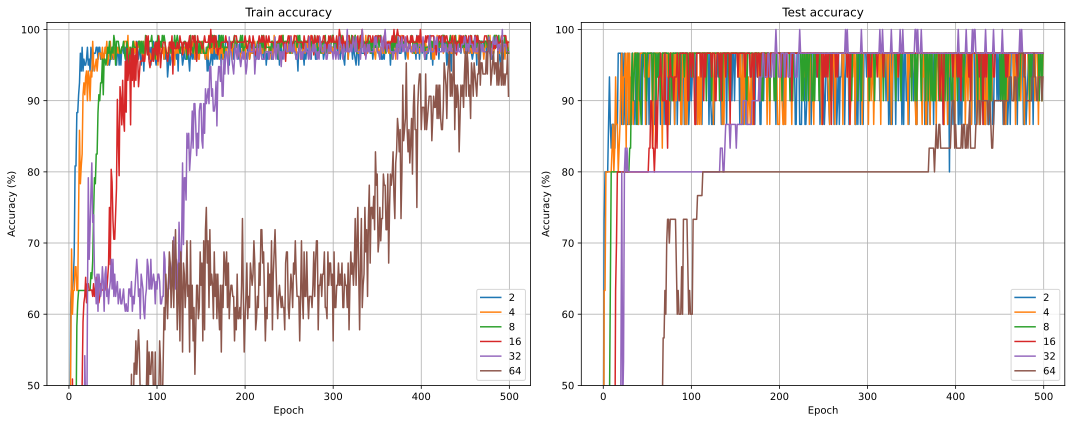

In [10]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(accuracy_train)
ax[0].set_title("Train accuracy")
ax[1].plot(accuracy_validation)
ax[1].set_title("Test accuracy")

# common features
for i in range(2):
    ax[i].legend(batch_sizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.tight_layout()
plt.show()

#### Observation(s)

```text
- It seems models trained with fewer batch size values learn the parameters faster compared with models trained with larger batch size values.
```